# Milestone P3

# Milestone Objectives

- Execute the project: single final notebook (main logic), helpers python file (implementations functions).

- Write a data story

- Update README: details the contributions of all group members.

[Milestone P3 briefing](https://epfl-ada.github.io/teaching/fall2023/cs401/projects/#p3-final-project-and-the-datastory)

In [25]:
import os
from helpers import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from implementations import *

import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'


In [ ]:
%run ./milestoneP2.ipynb

In [4]:
display(movies2_clean.sample(5))
display(movies2_clean.shape)
display(movies2_clean.info())

,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part
1688,171540,/m/0170th,The People vs. Larry Flynt,1996,129.0,[English Language],[USA],"[Biography, Comedy-drama, Period piece, Drama,...",6.8,257.0,20300385.0,0.002109
2319,18639038,/m/04gr_44,30 Years to Life,2003,110.0,[English Language],[USA],"[Romantic comedy, Ensemble Film, Romance Film,...",NaN,NaN,103540.0,0.000006
3718,1017650,/m/03zndp,Death Race 2000,1975,80.0,[English Language],[USA],"[Cult, Science Fiction, Indie, Sports, Action/...",6.0,125.0,6500000.0,0.004805
270,682275,/m/032kr9,The Preacher's Wife,1996,124.0,[English Language],[USA],"[Family Drama, Heavenly Comedy, Romantic fanta...",5.4,55.0,48093211.0,0.004997
2427,67419,/m/0hqr4,Out for Justice,1991,95.0,[English Language],[USA],"[Thriller, Action Thrillers, Gangster Film, Ac...",NaN,NaN,39673161.0,0.006499


(7285, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7285 entries, 0 to 7284
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_wiki       7285 non-null   int64  
 1   id_freebase   7285 non-null   object 
 2   name          7285 non-null   object 
 3   year          7285 non-null   int32  
 4   runtime       7260 non-null   float64
 5   lang          7285 non-null   object 
 6   countries     7285 non-null   object 
 7   genres        7285 non-null   object 
 8   review        2898 non-null   float64
 9   nbr_review    2898 non-null   float64
 10  revenue       7285 non-null   object 
 11  revenue_part  7285 non-null   object 
dtypes: float64(3), int32(1), int64(1), object(7)
memory usage: 654.6+ KB


None

## MEHDI

# Award dataset

In [5]:
DATA_PATH = '../data'
AWARDS_PATH = '/awards/oscars.csv'

In [6]:
awards = pd.read_csv(DATA_PATH+AWARDS_PATH).rename(columns={'year_film': 'year', 'category': 'cat_nominated', 'name': 'name_nominated', 'film': 'name'})
display(awards.sample(5))
display(awards.shape)
display(awards.info())

,year,year_ceremony,ceremony,cat_nominated,name_nominated,name,winner
7733,1997,1998,70,MUSIC (Original Dramatic Score),Philip Glass,Kundun,False
1573,1943,1944,16,MUSIC (Song),Music by Harold Arlen; Lyrics by Johnny Mercer,Star Spangled Rhythm,False
6685,1988,1989,61,ACTOR IN A SUPPORTING ROLE,Martin Landau,Tucker The Man and His Dream,False
6817,1989,1990,62,COSTUME DESIGN,Phyllis Dalton,Henry V,True
5824,1979,1980,52,WRITING (Screenplay Based on Material from Ano...,"Irving Ravetch, Harriet Frank, Jr.",Norma Rae,False


(10765, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10765 entries, 0 to 10764
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            10765 non-null  int64 
 1   year_ceremony   10765 non-null  int64 
 2   ceremony        10765 non-null  int64 
 3   cat_nominated   10765 non-null  object
 4   name_nominated  10761 non-null  object
 5   name            10450 non-null  object
 6   winner          10765 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 515.2+ KB


None

In [7]:
# Get rid of missing name rows

awards_clean = awards.copy()
awards_clean = awards.loc[~awards['name'].isna()].reset_index(drop=True)
display(awards_clean.sample(5))
display(awards_clean.shape)
display(awards_clean.info())

,year,year_ceremony,ceremony,cat_nominated,name_nominated,name,winner
3411,1959,1960,32,MUSIC (Scoring of a Musical Picture),"Andre Previn, Ken Darby",Porgy and Bess,True
2168,1948,1949,21,SHORT SUBJECT (Two-reel),"Gordon Hollingshead, Producer",Calgary Stampede,False
2459,1951,1952,24,DOCUMENTARY (Feature),"Olle Nordemar, Producer",Kon-Tiki,True
6401,1987,1988,60,DOCUMENTARY (Feature),"Robert Stone, Producer",Radio Bikini,False
1584,1944,1945,17,ART DIRECTION (Black-and-White),"Art Direction: Lionel Banks, Walter Holscher;...",Address Unknown,False


(10450, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            10450 non-null  int64 
 1   year_ceremony   10450 non-null  int64 
 2   ceremony        10450 non-null  int64 
 3   cat_nominated   10450 non-null  object
 4   name_nominated  10450 non-null  object
 5   name            10450 non-null  object
 6   winner          10450 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 500.2+ KB


None

In [8]:
generate_missing_info(awards_clean)

,Missing Data (%)
Column,
year,0.0
year_ceremony,0.0
ceremony,0.0
cat_nominated,0.0
name_nominated,0.0
name,0.0
winner,0.0


In [9]:
awards_clean.cat_nominated.unique()

array(['ACTOR', 'ACTRESS', 'ART DIRECTION', 'CINEMATOGRAPHY',
       'DIRECTING (Comedy Picture)', 'DIRECTING (Dramatic Picture)',
       'ENGINEERING EFFECTS', 'OUTSTANDING PICTURE',
       'UNIQUE AND ARTISTIC PICTURE', 'WRITING (Adaptation)',
       'WRITING (Original Story)', 'WRITING (Title Writing)', 'DIRECTING',
       'WRITING', 'OUTSTANDING PRODUCTION', 'SOUND RECORDING',
       'SHORT SUBJECT (Cartoon)', 'SHORT SUBJECT (Comedy)',
       'SHORT SUBJECT (Novelty)', 'ASSISTANT DIRECTOR', 'FILM EDITING',
       'MUSIC (Scoring)', 'MUSIC (Song)', 'DANCE DIRECTION',
       'WRITING (Screenplay)', 'ACTOR IN A SUPPORTING ROLE',
       'ACTRESS IN A SUPPORTING ROLE', 'SHORT SUBJECT (Color)',
       'SHORT SUBJECT (One-reel)', 'SHORT SUBJECT (Two-reel)',
       'MUSIC (Original Score)', 'CINEMATOGRAPHY (Black-and-White)',
       'CINEMATOGRAPHY (Color)', 'SPECIAL EFFECTS',
       'ART DIRECTION (Black-and-White)', 'ART DIRECTION (Color)',
       'WRITING (Original Screenplay)', 'DOCUME

In [10]:
check_doublons(awards_clean, ['name'], 'year', 'ceremony')

Rows with real duplicates: 
                                    name  year  ceremony
1                       The Last Command  1927         1
3                             7th Heaven  1927         1
5                                Sunrise  1927         1
7                             7th Heaven  1927         1
9                                Sunrise  1927         1
...                                  ...   ...       ...
10444          The Banshees of Inisherin  2022        95
10445  Everything Everywhere All at Once  2022        95
10446                      The Fabelmans  2022        95
10447                                Tár  2022        95
10448                Triangle of Sadness  2022        95

[7020 rows x 3 columns]
--------------------------------------------------------------------------------


In [11]:
awards_clean[awards_clean['name']=='7th Heaven']

,year,year_ceremony,ceremony,cat_nominated,name_nominated,name,winner
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
7,1927,1928,1,ART DIRECTION,Harry Oliver,7th Heaven,False
13,1927,1928,1,DIRECTING (Dramatic Picture),Frank Borzage,7th Heaven,True
18,1927,1928,1,OUTSTANDING PICTURE,Fox,7th Heaven,False
25,1927,1928,1,WRITING (Adaptation),Benjamin Glazer,7th Heaven,True


In [12]:
awards_condensed = awards_clean.copy()
aggregation_functions = {
    'year': 'first',
    'year_ceremony': 'first',
    'ceremony': 'first',
    'cat_nominated': list,
    'name_nominated': list,
    'winner': list
}

awards_condensed = awards_clean.groupby('name').agg(aggregation_functions).reset_index()

display(awards_condensed.sample(5))
display(awards_condensed.shape)
display(awards_condensed.info())

,name,year,year_ceremony,ceremony,cat_nominated,name_nominated,winner
3460,The Bigger Picture,2014,2015,87,[SHORT FILM (Animated)],[Daisy Jacobs and Christopher Hees],[False]
4867,Who's Afraid of Virginia Woolf?,1966,1967,39,"[ACTOR, ACTOR IN A SUPPORTING ROLE, ACTRESS, A...","[Richard Burton, George Segal, Elizabeth Taylo...","[False, False, True, True, True, True, True, F..."
812,Chocolat,2000,2001,73,"[ACTRESS IN A LEADING ROLE, ACTRESS IN A SUPPO...","[Juliette Binoche, Judi Dench, Rachel Portman,...","[False, False, False, False, False]"
1098,Drive My Car,2021,2022,94,"[DIRECTING, INTERNATIONAL FEATURE FILM, BEST P...","[Ryusuke Hamaguchi, Japan, Teruhisa Yamamoto, ...","[False, True, False, False]"
4133,The Pig,2008,2009,81,[SHORT FILM (Live Action)],[Tivi Magnusson and Dorte Høgh],[False]


(4991, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4991 entries, 0 to 4990
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            4991 non-null   object
 1   year            4991 non-null   int64 
 2   year_ceremony   4991 non-null   int64 
 3   ceremony        4991 non-null   int64 
 4   cat_nominated   4991 non-null   object
 5   name_nominated  4991 non-null   object
 6   winner          4991 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.1+ KB


None

In [13]:
awards_condensed[awards_condensed['name']=='7th Heaven']

,name,year,year_ceremony,ceremony,cat_nominated,name_nominated,winner
39,7th Heaven,1927,1928,1,"[ACTRESS, ART DIRECTION, DIRECTING (Dramatic P...","[Janet Gaynor, Harry Oliver, Frank Borzage, Fo...","[True, False, True, False, True]"


(array([274., 696., 569., 472., 478., 430., 501., 480., 543., 548.]),
 array([1927. , 1936.5, 1946. , 1955.5, 1965. , 1974.5, 1984. , 1993.5,
        2003. , 2012.5, 2022. ]),
 [<matplotlib.patches.Polygon at 0x1f0a1bce430>])

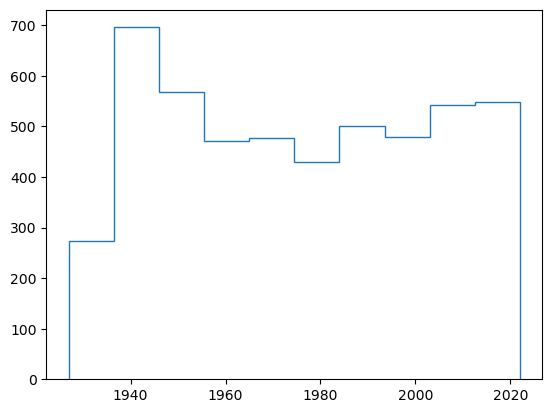

In [14]:
plt.hist(awards_condensed.year, histtype='step') 

# Trying to get more ratings 

In [18]:
BIG_RATINGS_PATH = '/ml-latest/ratings.csv'

In [26]:
spark = SparkSession.builder.appName("Ratings").getOrCreate()
big_ratings = spark.read.csv(DATA_PATH+BIG_RATINGS_PATH, header=True, inferSchema=True)
big_ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      1|   4.0|1225734739|
|     1|    110|   4.0|1225865086|
|     1|    158|   4.0|1225733503|
|     1|    260|   4.5|1225735204|
|     1|    356|   5.0|1225735119|
+------+-------+------+----------+
only showing top 5 rows



In [27]:
big_ratings_clean = big_ratings.groupBy("movieId").agg(
    F.avg("rating").alias("average_rating"),
    F.count("rating").alias("nbr_ratings")
)

big_ratings_clean.show()

+-------+------------------+-----------+
|movieId|    average_rating|nbr_ratings|
+-------+------------------+-----------+
|   1959| 3.633800573431029|       6278|
|   1591|2.6484306887532694|       6882|
|   1580| 3.595333426758223|      49951|
|   1645|  3.56697669143084|      17633|
|  44022|3.2430483271375463|       6725|
|   3175| 3.602825957745718|      18507|
|  32460|4.0208131655372705|       1033|
| 280218|3.4652701212789414|        907|
|    148|               2.9|        380|
|    471| 3.651588858375834|      12745|
|   8638| 4.005075757575757|       6600|
|  96488| 3.993886230728336|       1881|
|    496|3.3140877598152425|        433|
|   1088| 3.274450709702508|      15429|
|   2366|3.4753840782122905|       8592|
|   3918| 3.014236902050114|       1756|
|   1342|  3.02922642329422|       4602|
|  54190| 3.552968186290587|       3049|
|   7833| 3.819178082191781|        365|
|  31983|           3.53125|         48|
+-------+------------------+-----------+
only showing top

In [29]:
num_rows = big_ratings_clean.count()
num_columns = len(big_ratings_clean.columns)
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 83239
Number of columns: 3


In [30]:
big_ratings_pd = big_ratings_clean.toPandas()
display(big_ratings_pd.sample(5))
display(big_ratings_pd.shape)
display(big_ratings_pd.info())

,movieId,average_rating,nbr_ratings
81013,208685,3.000000,1
77548,130271,2.600000,5
57113,121374,4.008811,227
4415,271232,2.901728,463
34888,86766,4.000000,7


(83239, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83239 entries, 0 to 83238
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movieId         83239 non-null  int32  
 1   average_rating  83239 non-null  float64
 2   nbr_ratings     83239 non-null  int64  
dtypes: float64(1), int32(1), int64(1)
memory usage: 1.6 MB


None

## Building MEGA Annex using previous extra DFs of M2 and new DFs

In [32]:
display(movies_stats.sample(5))
display(movies_stats.shape)
display(movies_stats.info())
display(generate_missing_info(movies_stats))
display(check_doublons(movies_stats, ['name'], 'year', 'runtime'))

,name,year,review,nbr_review,countries,revenue,runtime
7111,Rough Night,2017,5.2,49000.0,United States,47347283.0,101.0
4253,Lost in Translation,2003,7.7,426000.0,United States,118686937.0,102.0
3892,Behind Enemy Lines,2001,6.4,100000.0,United States,91753202.0,106.0
6269,Now You See Me,2013,7.2,612000.0,United States,351723989.0,115.0
2053,Scent of a Woman,1992,8.0,274000.0,United States,134095253.0,156.0


(5377, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 5377 entries, 1 to 7659
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        5377 non-null   object 
 1   year        5377 non-null   int64  
 2   review      5377 non-null   float64
 3   nbr_review  5377 non-null   float64
 4   countries   5377 non-null   object 
 5   revenue     5377 non-null   float64
 6   runtime     5376 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 336.1+ KB


None

,Missing Data (%)
Column,
name,0.00
year,0.00
review,0.00
nbr_review,0.00
countries,0.00
revenue,0.00
runtime,0.02


No duplicates
--------------------------------------------------------------------------------


None

In [40]:
# Load MovieLens DF, need to modify it compared to M2 !

movies_lens_vanilla = pd.read_csv(MOVIE_LENS, usecols=['id', 'title', 'release_date', 'production_countries', 'revenue', 'runtime'])
movies_lens_vanilla = movies_lens_vanilla.rename(columns={'production_countries': 'countries',                                                     
                                                         'title': 'name'})
display(movies_lens_vanilla.sample(5))
display(movies_lens_vanilla.shape)
display(movies_lens_vanilla.info())

,id,countries,release_date,revenue,runtime,name
27124,198214,"[{'iso_3166_1': 'US', 'name': 'United States o...",2013-05-27,0.0,90.0,Ring of Fire
2690,10154,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1999-08-16,0.0,102.0,Mickey Blue Eyes
39075,291863,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2014-09-19,0.0,110.0,Future Shock! The Story of 2000AD
23981,211065,"[{'iso_3166_1': 'US', 'name': 'United States o...",2013-09-19,0.0,122.0,Proxy
29957,61041,"[{'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_...",1967-06-26,0.0,100.0,Woman Times Seven


(45466, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            45466 non-null  object 
 1   countries     45463 non-null  object 
 2   release_date  45379 non-null  object 
 3   revenue       45460 non-null  float64
 4   runtime       45203 non-null  float64
 5   name          45460 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.1+ MB


None

In [41]:
# WASH MACHINE

movies_lens = movies_lens_vanilla.copy(deep=True)
zero_data = movies_lens[(movies_lens.revenue <= 0)|(movies_lens.revenue.isna()|movies_lens.release_date.isna())]
movies_lens.drop(zero_data.index,inplace=True)
movies_lens.reset_index(drop=True, inplace=True)

movies_lens.loc[:, 'year'] = movies_lens['release_date'].str.split('-', expand=True)[0]
movies_lens.loc[:, 'year'] = movies_lens['year'].astype(int)
movies_lens = movies_lens.drop(columns='release_date')


movies_lens.loc[movies_lens['runtime'] < 0, 'runtime'] = 0
movies_lens['runtime'] = movies_lens['runtime'].replace(0, pd.NA)

movies_lens['year'] = movies_lens['year'].astype(int)
movies_lens['runtime'] = pd.to_numeric(movies_lens['runtime'], errors='coerce')

# Handling format
movies_lens['countries'] = movies_lens['countries'].apply(lambda x: [country['name'] for country in ast.literal_eval(x)] if pd.notna(x) else [])

# Handle multi-countries movies to keep only one country per movie (prioritize USA above others)
movies_lens = separate_values_biased(movies_lens, 'countries', 'United States of America')
movies_lens = movies_lens[movies_lens['countries']=='United States of America'].drop(columns='countries')

display(check_doublons(movies_lens, ['name'], 'year', 'runtime'))

movies_lens = fuse_duplicates(movies_lens, col_check=['name'], year='year', runtime='runtime',
                         col_len=[], col_null=['revenue'])

check_doublons(movies_lens, ['name'], 'year', 'runtime')


display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())


Rows with real duplicates: 
                                             name  year  runtime
415                            A Farewell to Arms  1932     89.0
2301                                Clockstoppers  2002     94.0
2444  Pokémon 4Ever: Celebi - Voice of the Forest  2001     75.0
2548              Confessions of a Dangerous Mind  2002    113.0
4721                           A Farewell to Arms  1932     89.0
6692                                Clockstoppers  2002     94.0
6695              Confessions of a Dangerous Mind  2002    113.0
7381  Pokémon 4Ever: Celebi - Voice of the Forest  2001     75.0
--------------------------------------------------------------------------------


None

Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
No duplicates
--------------------------------------------------------------------------------


,id,revenue,runtime,name,year
4673,160588,9.920622e+07,98.0,Blue Jasmine,2013
351,963,1.000000e+06,100.0,The Maltese Falcon,1941
5435,337874,2.302000e+04,102.0,Goat,2016
1318,14040,1.400000e+06,113.0,American Flyers,1985
4336,49026,1.084939e+09,165.0,The Dark Knight Rises,2012


(5619, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       5619 non-null   object 
 1   revenue  5619 non-null   float64
 2   runtime  5619 non-null   float64
 3   name     5619 non-null   object 
 4   year     5619 non-null   int32  
dtypes: float64(2), int32(1), object(2)
memory usage: 197.7+ KB


None

## TRASH CAN UNDERNEATH

In [15]:
movies3 = movies2_clean.copy()
movies3 = pd.merge(movies2_clean, awards_condensed, on=['name', 'year'], how='left')

display(movies3.sample(5))
display(movies3.shape)
display(movies3.info())

,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part,year_ceremony,ceremony,cat_nominated,name_nominated,winner
1515,6469252,/m/0g6j0h,Shooter,2007,126.0,[English Language],[USA],"[Thriller, Film adaptation, Action/Adventure, ...",NaN,NaN,95696996.0,0.004946,NaN,NaN,NaN,NaN,NaN
5349,23270459,/m/0661ql3,Inception,2010,148.0,"[French Language, Japanese Language, English L...","[USA, United Kingdom]","[Thriller, Science Fiction, Adventure, Psychol...",8.795340,2114075.0,828358814.75,0.03707,2011.0,83.0,"[ART DIRECTION, CINEMATOGRAPHY, MUSIC (Origina...",[Production Design: Guy Hendrix Dyas; Set Deco...,"[False, True, False, False, True, True, True, ..."
1191,7271954,/m/0kv2w7,Blood and Chocolate,2007,98.0,"[Romanian Language, English Language]","[USA, Romania, United Kingdom, Germany]","[Crime Fiction, Horror, Creature Film, Drama, ...",NaN,NaN,6311117.0,0.000326,NaN,NaN,NaN,NaN,NaN
5709,770156,/m/03b1n2,But I'm a Cheerleader,1999,85.0,[English Language],[USA],"[Romantic comedy, Gay Interest, Comedy-drama, ...",6.699306,29101.0,2596412.0,0.0002,NaN,NaN,NaN,NaN,NaN
3264,18996,/m/04ssf,Mean Streets,1973,112.0,"[Italian Language, English Language]",[USA],"[Crime Fiction, Drama, Coming of age, Gangster...",NaN,NaN,3000000.0,0.002468,NaN,NaN,NaN,NaN,NaN


(7285, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7285 entries, 0 to 7284
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_wiki         7285 non-null   int64  
 1   id_freebase     7285 non-null   object 
 2   name            7285 non-null   object 
 3   year            7285 non-null   int32  
 4   runtime         7260 non-null   float64
 5   lang            7285 non-null   object 
 6   countries       7285 non-null   object 
 7   genres          7285 non-null   object 
 8   review          2898 non-null   float64
 9   nbr_review      2898 non-null   float64
 10  revenue         7285 non-null   object 
 11  revenue_part    7285 non-null   object 
 12  year_ceremony   1277 non-null   float64
 13  ceremony        1277 non-null   float64
 14  cat_nominated   1277 non-null   object 
 15  name_nominated  1277 non-null   object 
 16  winner          1277 non-null   object 
dtypes: float64(5), int32(1), int64(1)

None

In [16]:
movies3['oscar_nomination'] = pd.notna(movies3['ceremony'])

In [17]:
movies3.insert(movies3.columns.get_loc('revenue_part') + 1, 'oscar_nomination', movies3.pop('oscar_nomination'))
movies3 = movies3.drop(columns=['year_ceremony', 'ceremony'])

display(movies3.sample(5))
display(movies3.shape) 
display(movies3.info())

,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part,oscar_nomination,cat_nominated,name_nominated,winner
5439,30296552,/m/0g5r4sy,Another Earth,2011,90.0,[English Language],[USA],"[Science Fiction, Mystery, Fantasy, Drama, Rom...",NaN,NaN,1776935.0,0.000077,False,NaN,NaN,NaN
651,779536,/m/03bq6g,Fat Man and Little Boy,1989,126.0,[English Language],[USA],"[Period piece, Drama, War film]",NaN,NaN,3563162.0,0.000595,False,NaN,NaN,NaN
1565,4845206,/m/0cqnq8,Sodom and Gomorrah,1962,120.0,[English Language],"[USA, France, Italy]","[History, Drama, Adventure, Historical drama]",NaN,NaN,2300000.0,0.008804,False,NaN,NaN,NaN
2013,430975,/m/027p7w,Harvard Man,2002,99.0,[English Language],"[USA, Canada]","[Crime Fiction, Thriller, Gangster Film, Indie...",NaN,NaN,56653.0,0.000003,False,NaN,NaN,NaN
3056,386476,/m/0227ry,The Frisco Kid,1979,114.0,[English Language],[USA],"[Action/Adventure, Western, Buddy film, Comedy...",6.0,38.0,9346177.0,0.004882,False,NaN,NaN,NaN


(7285, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7285 entries, 0 to 7284
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_wiki           7285 non-null   int64  
 1   id_freebase       7285 non-null   object 
 2   name              7285 non-null   object 
 3   year              7285 non-null   int32  
 4   runtime           7260 non-null   float64
 5   lang              7285 non-null   object 
 6   countries         7285 non-null   object 
 7   genres            7285 non-null   object 
 8   review            2898 non-null   float64
 9   nbr_review        2898 non-null   float64
 10  revenue           7285 non-null   object 
 11  revenue_part      7285 non-null   object 
 12  oscar_nomination  7285 non-null   bool   
 13  cat_nominated     1277 non-null   object 
 14  name_nominated    1277 non-null   object 
 15  winner            1277 non-null   object 
dtypes: bool(1), float64(3), int32(1), int64(1)

None